# ANALYSING US FATAL POLICE SHOOTINGS FROM 2015-2020

This dataset is taken from The Washington Post's [Github repository](https://github.com/washingtonpost/data-police-shootings). It contains data related to every fatal shooting of a civilian by a police officer in the States in the line of duty. The time duration is from the start of the year 2015 to June 2020. The Post decided to collect data regarding these shootings after the unfortunate death of Micheal Brown. Sources of this data are news accounts, social media posts and police reports.

I will be performing an Exploratory Data Analysis on this dataset.

In [107]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ustate/gz_2010_us_040_00_5m.json
/kaggle/input/usps20/2015.csv
/kaggle/input/usps20/2017.csv
/kaggle/input/usps20/2016.csv
/kaggle/input/usps20/2018.csv
/kaggle/input/usps20/usps.csv


**DATA WRANGLING AND CLEANING:**

In [108]:
us_state=gpd.read_file('../input/ustate/gz_2010_us_040_00_5m.json')

In [109]:
usps=pd.read_csv('/kaggle/input/usps20/usps.csv')
usps.drop(['id','city'],axis=1,inplace=True)

In [110]:
usps.groupby(['race']).age.count()

race
A      90
B    1321
H     923
N      80
O      46
W    2558
Name: age, dtype: int64

In [111]:
usps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5716 entries, 0 to 5715
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     5499 non-null   object 
 1   date                     5716 non-null   object 
 2   manner_of_death          5716 non-null   object 
 3   armed                    5503 non-null   object 
 4   age                      5456 non-null   float64
 5   gender                   5715 non-null   object 
 6   race                     5109 non-null   object 
 7   state                    5716 non-null   object 
 8   signs_of_mental_illness  5716 non-null   bool   
 9   threat_level             5716 non-null   object 
 10  flee                     5426 non-null   object 
 11  body_camera              5716 non-null   bool   
 12  longitude                5437 non-null   float64
 13  latitude                 5437 non-null   float64
 14  is_geocoding_exact      

The dataset contains 16 columns out of which 3 are numerical, 3 are of boolean type and the rest are of type Object.

Brief description about the columns in this dataset:
1. **Name**- name of the deceased
2. **date**- date of the casualty
3. **manner_of_death**- was the victim only shot or shot and tasered.
4. **armed**- indicates whether the victim was having any object which could cause harm
5. **age**- age of the deceased
6. **gender**- sex of the victim
7. **race**- race of the victim, if specified. Contains 5 categories, Asian(A),White(W),Black(B),Hispanic(H),Others(O),Not Specified(N)
8. **city**- city where the casualty took place
9. **state**- self explanatory
10. **signs_of_mental_illness**- did the victim have mental health issues
11. **threat_level**- level of threat the officers felt they were up against.
12. **flee**- did the victim attempt to flee?
13. **body_camera**- did the officers have a body cam switched on?
14. **longitude**- longitude of the location of incident
15. **latitude**- latitude of the location of the incident
16. **is_geocoding_exact**- accuracy of the coordinates

In [112]:
#no. of data points in dataset, contains 5716 rows and 16 columns
usps.shape

(5716, 15)

In [113]:
#handling null values in age column
mean=usps.age.mean()
mean=round(mean)
mean

37

In [114]:
#replacing null values in age column with mean age value
usps['age']=usps['age'].fillna(37)

In [115]:
usps['gender']=usps['gender'].fillna('M')

In [116]:
#dropping all rows where race is not specified to avoid making biased conclusions
usps=usps[usps['race'].isna()==False]
usps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5711
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     5074 non-null   object 
 1   date                     5109 non-null   object 
 2   manner_of_death          5109 non-null   object 
 3   armed                    4906 non-null   object 
 4   age                      5109 non-null   float64
 5   gender                   5109 non-null   object 
 6   race                     5109 non-null   object 
 7   state                    5109 non-null   object 
 8   signs_of_mental_illness  5109 non-null   bool   
 9   threat_level             5109 non-null   object 
 10  flee                     4874 non-null   object 
 11  body_camera              5109 non-null   bool   
 12  longitude                4886 non-null   float64
 13  latitude                 4886 non-null   float64
 14  is_geocoding_exact      

**NOTE:** One could observe that there are significant number of null values in some columns of the dataset, but since the analysis I am doing is based on a sensitive topic, it would be a mistake to try to estimate the missing values of any of the columns above. Therefore I have chosen to get along with the analysis.

In [117]:
#filling nan values in flee column
usps['flee'].fillna('NotSpecified',inplace=True)

Splitting the "Date" column:

In [118]:
#splitting date into 3 columns year month and day
usps['year']=pd.DatetimeIndex(usps['date']).year
usps['month']=pd.DatetimeIndex(usps['date']).strftime('%b')
usps['day']=pd.DatetimeIndex(usps['date']).strftime('%A')
usps.drop(['date'],axis=1,inplace=True)

In [119]:
sns.set_style('darkgrid')

**The dataset is now ready for analysis**

**DATA ANALYSIS AND VISUALISATION**

FATALITIES REPORTED ACROSS STATES

In [120]:
usps.groupby(['state']).state.count().sort_values(ascending=False)

state
CA    733
TX    450
FL    345
AZ    226
CO    181
GA    172
OK    156
NC    156
OH    150
WA    133
TN    130
MO    126
LA    109
IL    103
PA     99
NM     97
AL     95
NY     94
IN     94
KY     93
VA     93
WI     92
NV     90
SC     83
MD     78
OR     77
MI     77
AR     73
UT     67
MN     63
MS     62
NJ     62
KS     50
WV     46
ID     38
AK     36
IA     34
MA     33
MT     31
HI     29
NE     25
ME     21
CT     20
DC     14
SD     14
WY     13
ND     12
NH     12
DE     10
VT      8
RI      4
Name: state, dtype: int64

We observe that California has the highest number of fatal shootings followed by Texas, Florida and Arizona.

In [121]:
usps.head()

,name,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,year,month,day
0,Tim Elliot,shot,gun,53.0,M,A,WA,True,attack,Not fleeing,False,-123.122,47.247,True,2015,Jan,Friday
1,Lewis Lee Lembke,shot,gun,47.0,M,W,OR,False,attack,Not fleeing,False,-122.892,45.487,True,2015,Jan,Friday
2,John Paul Quintero,shot and Tasered,unarmed,23.0,M,H,KS,False,other,Not fleeing,False,-97.281,37.695,True,2015,Jan,Saturday
3,Matthew Hoffman,shot,toy weapon,32.0,M,W,CA,True,attack,Not fleeing,False,-122.422,37.763,True,2015,Jan,Sunday
4,Michael Rodriguez,shot,nail gun,39.0,M,H,CO,False,attack,Not fleeing,False,-104.692,40.384,True,2015,Jan,Sunday


IDENTIFYING UNIQUE VALUES OF RELEVANT COLUMNS IN THE DATASET

In [122]:
li=['manner_of_death','armed','gender','race','state','flee','threat_level','signs_of_mental_illness']
for col in li:
    print(col)
    print(usps[col].unique())

manner_of_death
['shot' 'shot and Tasered']
armed
['gun' 'unarmed' 'toy weapon' 'nail gun' 'knife' nan 'shovel' 'vehicle'
 'hammer' 'hatchet' 'sword' 'machete' 'box cutter' 'undetermined'
 'metal object' 'screwdriver' 'lawn mower blade' 'flagpole'
 'guns and explosives' 'cordless drill' 'metal pole' 'Taser' 'metal pipe'
 'metal hand tool' 'blunt object' 'metal stick' 'sharp object'
 'meat cleaver' 'carjack' 'chain' "contractor's level" 'unknown weapon'
 'stapler' 'crossbow' 'bean-bag gun' 'baseball bat and fireplace poker'
 'straight edge razor' 'gun and knife' 'ax' 'brick' 'baseball bat'
 'hand torch' 'chain saw' 'garden tool' 'scissors' 'pole' 'pick-axe'
 'flashlight' 'spear' 'chair' 'pitchfork' 'hatchet and gun' 'rock'
 'piece of wood' 'bayonet' 'pipe' 'glass shard' 'motorcycle'
 'pepper spray' 'metal rake' 'baton' 'crowbar' 'oar' 'machete and gun'
 'air conditioner' 'pole and knife' 'beer bottle'
 'baseball bat and bottle' 'fireworks' 'pen' 'chainsaw' 'gun and sword'
 'gun and car'

Modifying "armed" column of dataset

Upon careful observation, to make the analysis of incidents less ambiguous, I have classified certain values in "armed" column as harmless and the rest as harmful. The values in list "unarmed" will be replaced by 'No' and the rest will be replaced with 'Yes'.

In [123]:
unarmed=['unarmed','blunt object',"contractor's level",'stapler','flashlight','chair','rock','pepper spray','pen','wasp spray','baton']
blank=[]
for i in usps['armed']:
    if i in unarmed:
        blank.append('No')
    else:
        blank.append('Yes')
usps['weapon']=blank

#created a new column weapon which has a value Yes if the object posessed by the victim was harmful and No if it was not harmful.

In [124]:
usps.head()

,name,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,year,month,day,weapon
0,Tim Elliot,shot,gun,53.0,M,A,WA,True,attack,Not fleeing,False,-123.122,47.247,True,2015,Jan,Friday,Yes
1,Lewis Lee Lembke,shot,gun,47.0,M,W,OR,False,attack,Not fleeing,False,-122.892,45.487,True,2015,Jan,Friday,Yes
2,John Paul Quintero,shot and Tasered,unarmed,23.0,M,H,KS,False,other,Not fleeing,False,-97.281,37.695,True,2015,Jan,Saturday,No
3,Matthew Hoffman,shot,toy weapon,32.0,M,W,CA,True,attack,Not fleeing,False,-122.422,37.763,True,2015,Jan,Sunday,Yes
4,Michael Rodriguez,shot,nail gun,39.0,M,H,CO,False,attack,Not fleeing,False,-104.692,40.384,True,2015,Jan,Sunday,Yes


**PLOTTING INCIDENTS ON A WORLD MAP**

In [125]:
usps['coordinates']=usps[['longitude','latitude']].values.tolist()

In [126]:
usps['coordinates'] = usps['coordinates'].apply(Point)

In [127]:
usmap=gpd.GeoDataFrame(usps, geometry='coordinates')

In [128]:
usps.head()

,name,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,year,month,day,weapon,coordinates
0,Tim Elliot,shot,gun,53.0,M,A,WA,True,attack,Not fleeing,False,-123.122,47.247,True,2015,Jan,Friday,Yes,POINT (-123.12200 47.24700)
1,Lewis Lee Lembke,shot,gun,47.0,M,W,OR,False,attack,Not fleeing,False,-122.892,45.487,True,2015,Jan,Friday,Yes,POINT (-122.89200 45.48700)
2,John Paul Quintero,shot and Tasered,unarmed,23.0,M,H,KS,False,other,Not fleeing,False,-97.281,37.695,True,2015,Jan,Saturday,No,POINT (-97.28100 37.69500)
3,Matthew Hoffman,shot,toy weapon,32.0,M,W,CA,True,attack,Not fleeing,False,-122.422,37.763,True,2015,Jan,Sunday,Yes,POINT (-122.42200 37.76300)
4,Michael Rodriguez,shot,nail gun,39.0,M,H,CO,False,attack,Not fleeing,False,-104.692,40.384,True,2015,Jan,Sunday,Yes,POINT (-104.69200 40.38400)


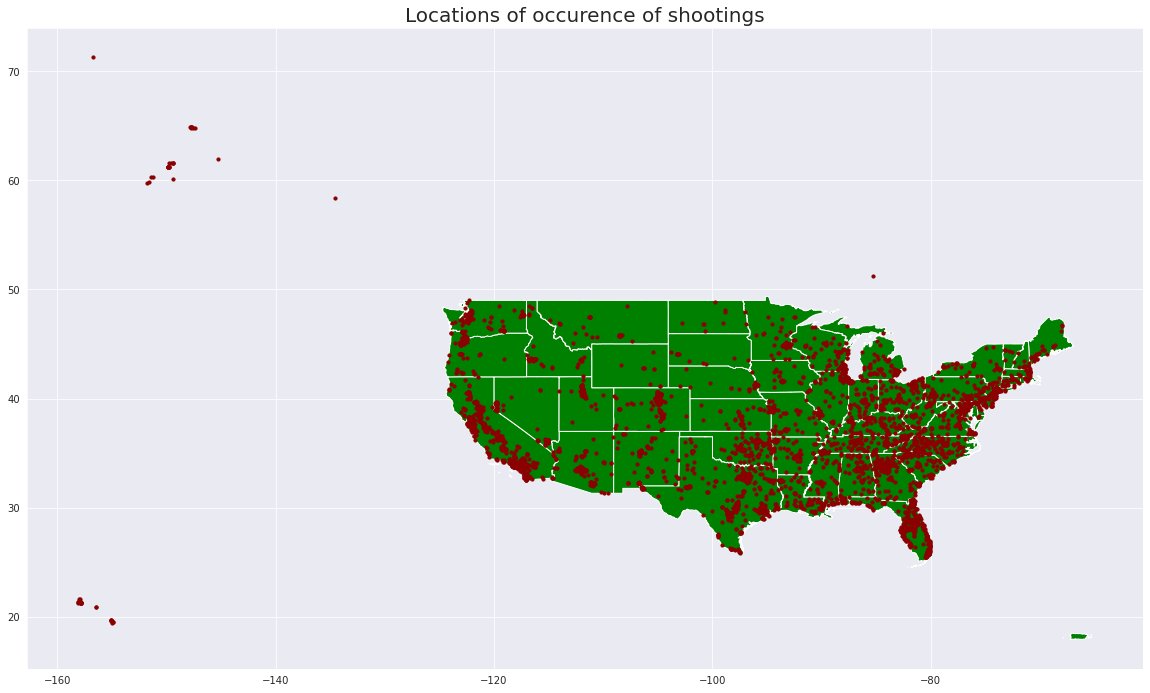

In [129]:
fig, ax = plt.subplots(1, figsize=(20,15))
base = us_state[us_state['NAME'].isin(['Alaska','Hawaii']) == False].plot(ax=ax, color='Green')
ax.set_title('Locations of occurence of shootings',fontsize=20)
usmap.plot(ax=base, color='darkred', marker="o", markersize=10);

**DISTRIBUTION OF FATALITIES BY AGE**

(array([   7.,  585., 1446., 1289.,  854.,  506.,  305.,   83.,   26.,
           8.]),
 array([ 6. , 14.5, 23. , 31.5, 40. , 48.5, 57. , 65.5, 74. , 82.5, 91. ]),
 <a list of 10 Patch objects>)

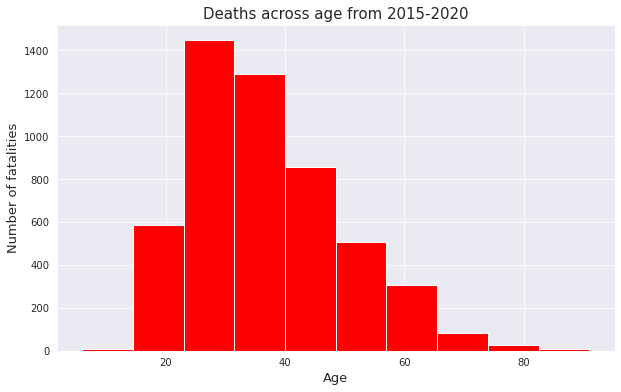

In [130]:
plt.figure(figsize=(10,6))
plt.title('Deaths across age from 2015-2020',size=15)
plt.xlabel('Age',size=13)
plt.ylabel('Number of fatalities',size=13)
plt.hist(usps['age'],color='red')

We observe that the number of deaths progressively decrease as the ages increase.Ages between 20-40 consitute over 50% of all reported casualties.Highest recorded number of deaths occur in the age group of 20 to ~30 upto 40. Lowest number is observed for ages over 60 and below 15.

**What is the maximum and minimum age of victims?**

In [131]:
usps['age'].describe()

count    5109.000000
mean       36.582306
std        12.647908
min         6.000000
25%        27.000000
50%        35.000000
75%        45.000000
max        91.000000
Name: age, dtype: float64

Youngest casualty was 6 years old and eldest was 91 years old. This is very unfortunate because people of these age groups are highly unlikely to be even involced in committing harm to anyone which points to on duty mistakes made by the police authorities. 

FATALITIES OVER THE YEARS

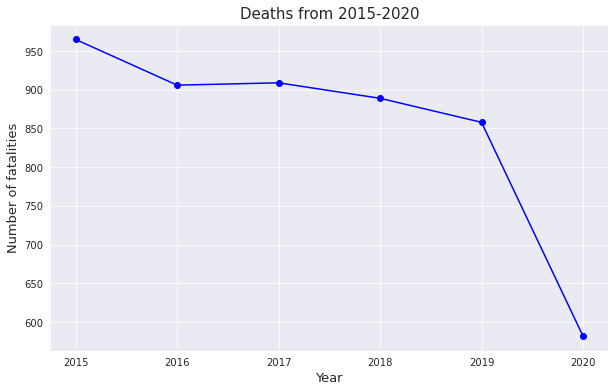

In [132]:
years=usps.groupby(['year']).year.count()
plt.figure(figsize=(10,6))
plt.title('Deaths from 2015-2020',size=15)
plt.xlabel('Year',size=13)
plt.ylabel('Number of fatalities',size=13)
plt.plot(years,color='blue',marker='o')

We observe that the number of civilian casualties per year has remained almost the same. Inspite of the citizen's outrage against these casualties,not much change has taken place. Harming civilians in any way is not viable.

CASUALTIES REPORTED IN EACH MONTH

In [133]:
months_df=pd.DataFrame({'month':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],'count':[509,467,505,433,419,427,445,441,372,390,354,347]})

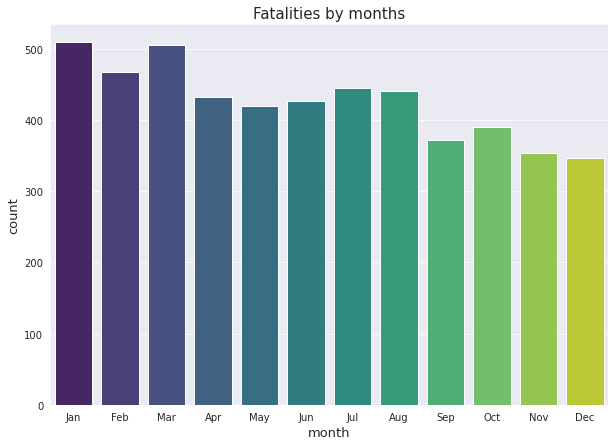

In [134]:
plt.figure(figsize=(10,7))
plt.title('Fatalities by months',size=15)
plt.xlabel('Month',size=13)
plt.ylabel('Number of fatalities',size=13)
sns.barplot(x='month',y='count',data=months_df,palette='viridis')

January had maximum number of casualties and December had the least number reported.

CASUALTIES REPORTED ON DAYS OF WEEK

In [135]:
days_df=pd.DataFrame({'Day':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],'count':[703,773,779,774,708,682,690]})

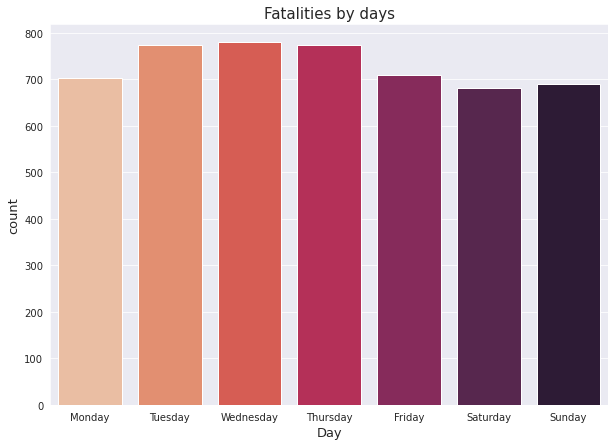

In [136]:
plt.figure(figsize=(10,7))
plt.title('Fatalities by days',size=15)
plt.xlabel('Day',size=13)
plt.ylabel('Number reported',size=13)
sns.barplot(x='Day',y='count',data=days_df,palette='rocket_r')

Maximum number of fatalities were reported on Tuesday,Wednesday and Thursday. Saturday has the lowest count.

In [137]:
usps.drop(['longitude','latitude','is_geocoding_exact','day','month','coordinates'],inplace=True,axis=1)

GENDERWISE DISTRIBUTION OF FATALITIES

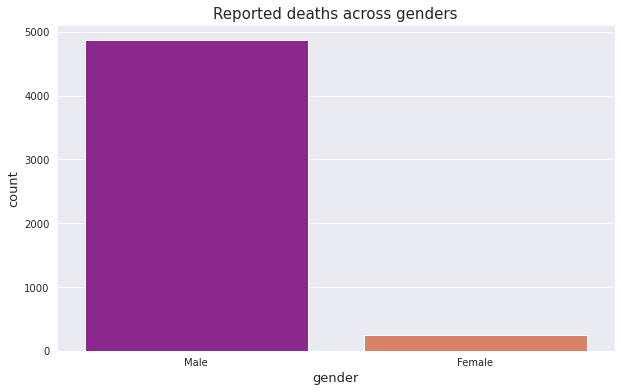

In [138]:
gender_df=pd.DataFrame({'gender':['Male','Female'],'count':[4869,240]})
plt.figure(figsize=(10,6))
plt.xlabel('gender',size=13)
plt.ylabel('fatalities',size=13)
plt.title('Reported deaths across genders',size=15)
sns.barplot(x='gender',y='count',data=gender_df,palette='plasma')

Although there is no sense of equality here, it is observed that almost 95% of all civilian victims were Male.

(array([ 8., 45., 52., 49., 31., 35., 14.,  2.,  3.,  1.]),
 array([12. , 19.2, 26.4, 33.6, 40.8, 48. , 55.2, 62.4, 69.6, 76.8, 84. ]),
 <a list of 10 Patch objects>)

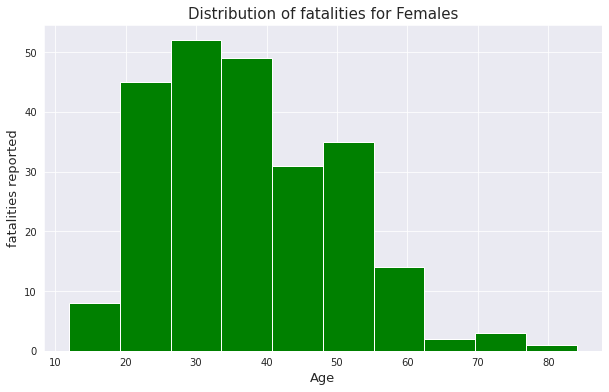

In [139]:
#distribution of fatalities among Females
female_df=usps.loc[usps['gender']=='F',:]
plt.figure(figsize=(10,6))
plt.xlabel('Age',size=13)
plt.ylabel('fatalities reported',size=13)
plt.title('Distribution of fatalities for Females',size=15)
plt.hist(female_df['age'],color='green')

It is observed that the age group 25-40 has recorded the most fatalities for females. Lowest count is for Ages above 60. Shockingly we see a significant number in the age group 10-20. Killing potentially harmless civilians is not defendable even if this happens in the line of duty.

The distribution for males is not plotted. Since males constitute over 95% of total victims, we expect its distribution to be the same as that for overall distribution of casualties.

ANALYSING THE STATUS OF BODY CAMERAS

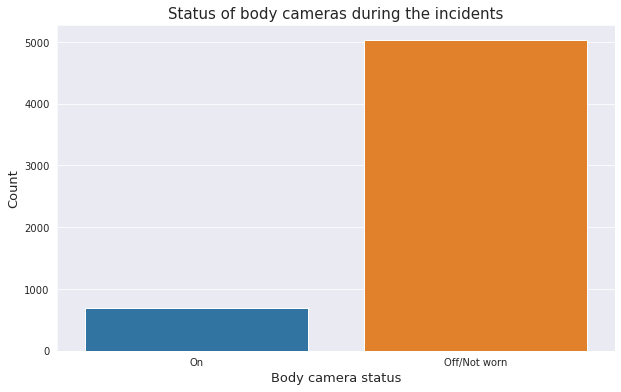

In [140]:
body_cam=pd.DataFrame({'Body camera status':['On','Off/Not worn'],'Count':[687,5029]})
plt.figure(figsize=(10,6))
plt.xlabel('Body camera on?',size=13)
plt.ylabel('Count',size=13)
plt.title('Status of body cameras during the incidents',size=15)
sns.barplot(x='Body camera status',y='Count',data=body_cam)

As observed, in almost 90% of total reported fatal shootings, the body cameras were either not worn or turned off during the incident. This may raise nothing but suspicions. Reasons for unavailability of cameras could be that the department was not provided with them or the officers on duty refused to acknowledge their need. 

Whatever be the reasons, the body cameras not only render the police forces accountable for their actions, but also provide them recorded evidence in case the perpetrator misbehaves. It can be used to promote officer safety, ensure strict law enforcement and prevention of crimes. Moreover the recorded footage speeds up investigations too. Usage of such cameras limit the officers to execute legitimate actions and also make the citizens comply with their commands, thus ensuring quicker resolutions of situations.

This technology is of help to both the citizens and the police forces. Rarely would we have observed such fatalities being reported if the body cameras had been used, which is proven by the low count of fatalities when the cameras were present.


**ANALYSING THREAT_LEVEL of VICTIMS**

Were all victims having harmful intentions?

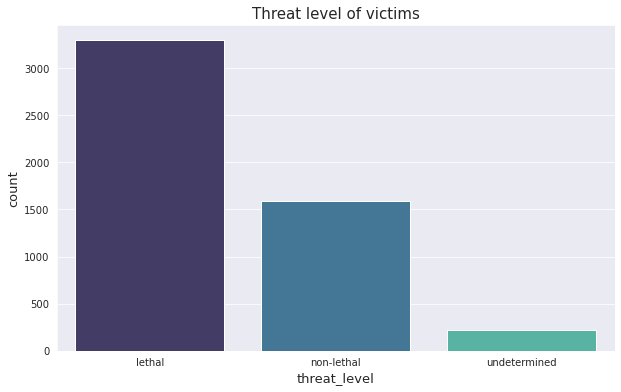

In [141]:
threat=usps.groupby(['threat_level']).threat_level.count()
threat_df=pd.DataFrame(data={'threat_level':['lethal','non-lethal','undetermined'],'count':[3295,1593,221]})
plt.figure(figsize=(10,6))
plt.title('Threat level of victims',size=15)
plt.xlabel('level reported',size=13)
plt.ylabel('Number of fatalities',size=13)
sns.barplot(data=threat_df,x='threat_level',y='count',palette='mako')

We find that more than 3000 civilians who were killed were reported to be lethal, whereas over 1500 were documented as non_lethal, yet were killed. Self-defense can be viable when someone attacks you but to fatally shoot someone who's harmless is not in accordance with the law. 

**FATALITIES REPORTED ACROSS VARIOUS RACES**

Comparison of casualties reported per year per race

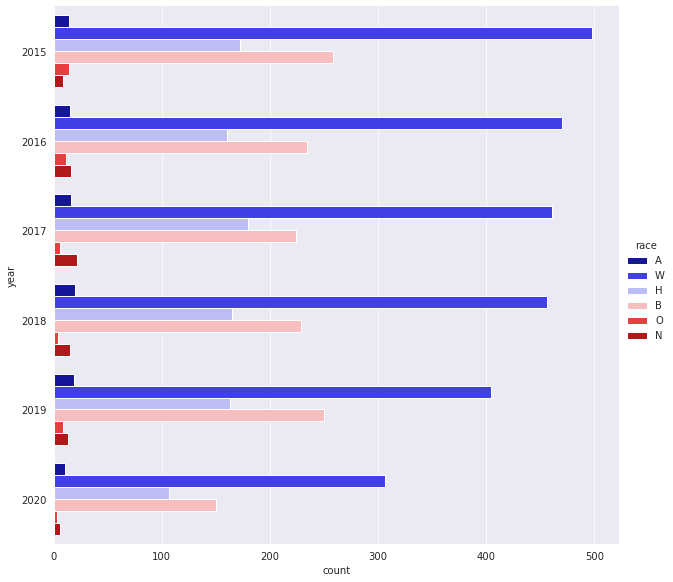

In [142]:
sns.catplot(y="year", hue="race", kind="count",palette="seismic",height=8, aspect=1.1,
            data=usps)

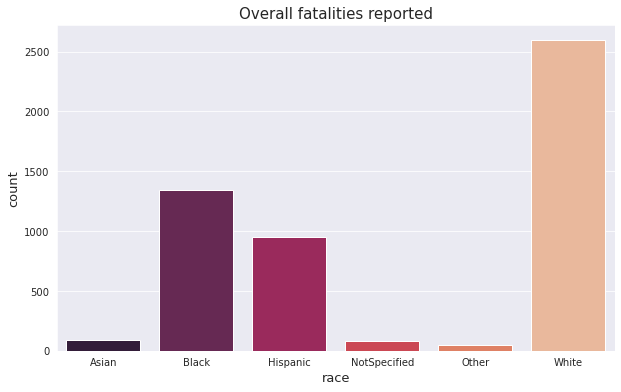

In [143]:
race=usps.groupby(['race']).race.count()
race_df=pd.DataFrame(data={'race':['Asian','Black','Hispanic','NotSpecified','Other','White'],'count':[94,1345,947,81,47,2595]})
plt.figure(figsize=(10,6))
plt.title('Overall fatalities reported',size=15)
plt.xlabel('race',size=13)
plt.ylabel('Number of fatalities',size=13)
sns.barplot(data=race_df,x='race',y='count',palette='rocket')

We observe that out of the 5109 reported shootings, majority of the victims were whites, which does not indicate any sort of racial bias. With the coming of new unfortunate controversial killings like that of George Floyd, racism has been a prevailing serious issue in America. A more accurate judgement on racial bias in these shootings can be made by comparing how many innocent and unarmed people were killed among these races.

FATALITIES ACROSS REGIONS

In [144]:
#categorising states across 4 major regions
ne=['ME','MA','NH','RI','VT','NJ','NY','PA']
mw=['IN','IL','MI','OH','WI','IA','NE','KS','ND','MN','SD','MO']
s=['DE','DC','FL','GA','MD','NC','SC','VA','WV','AL','KY','MS','TN','AR','LA','OK','TX']
w=['AZ','CO','ID','NM','MT','UT','NE','WY','AK','CA','HI','OR','WA']

In [145]:
#creating a region column that indicates the region in which a state belongs
rl=[]
for i in usps['state']:
    if i in ne:
        rl.append('NorthEast')
    elif i in mw:
        rl.append('MidWest')
    elif i in s:
        rl.append('South')
    else:
        rl.append('West')
usps['region']=rl        

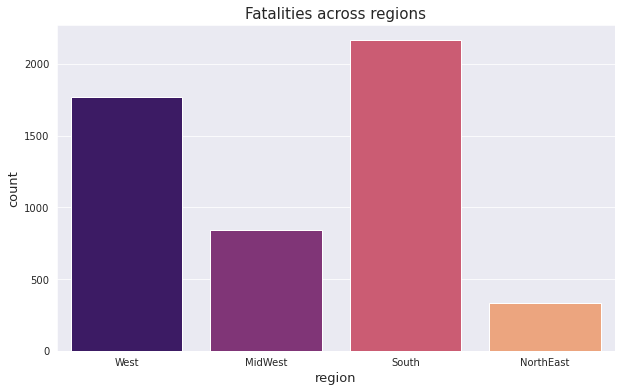

In [146]:
#fatalities across regions
plt.figure(figsize=(10,6))
plt.title('Fatalities across regions',size=15)
plt.xlabel('region',size=13)
plt.ylabel('count',size=13)
sns.countplot(data=usps,x='region',palette='magma')

Overall, Southern USA had the most reported fatalities. Counts of such incidents in the North East are the lowest, which indicates better handling of potentially harmful situations.

MENTAL STATE OF VICTIMS

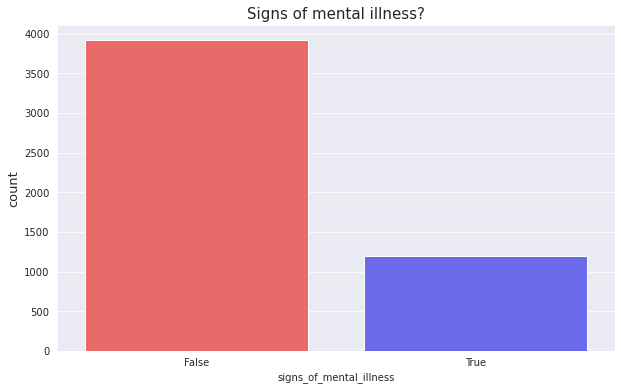

In [147]:
plt.figure(figsize=(10,6))
plt.title('Signs of mental illness?',size=15)
plt.ylabel('count',size=13)
sns.countplot(data=usps,x='signs_of_mental_illness',palette='seismic_r')

In [148]:
#finding out how many reported to be mentally ill and posing no threat were killed.
l=[]
for i in usps['threat_level']:
    if i=='attack':
        l.append('lethal')
    elif i=='other':
        l.append('non_lethal')
    else:
        l.append('undetermined')
usps['threat_level']=l 
un=usps.groupby(['signs_of_mental_illness','threat_level']).threat_level.count()
#draw its barplot

COMPARING MORTALITY RATES OF VICTIMS REPORTED AS NON-LETHAL AMONG ALL RACES.

In [149]:
usps.groupby(['race','threat_level']).threat_level.count()

race  threat_level
A     lethal            51
      non_lethal        41
      undetermined       2
B     lethal           904
      non_lethal       379
      undetermined      62
H     lethal           549
      non_lethal       348
      undetermined      50
N     lethal            46
      non_lethal        30
      undetermined       5
O     lethal            31
      non_lethal        16
W     lethal          1714
      non_lethal       779
      undetermined     102
Name: threat_level, dtype: int64

In [150]:
df=usps.groupby(['race']).race.count()

In [151]:
a=(41/94)*100
b=(379/1345)*100
h=(348/947)*100
n=(30/81)*100
w=(779/2595)*100
o=(16/47)*100
non_lethal=[a,b,h,n,w,o]
non_lethal.sort()

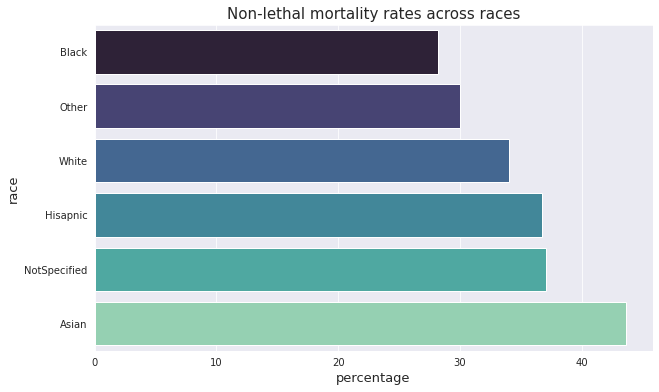

In [152]:
race=['Black','Other','White','Hisapnic','NotSpecified','Asian',]
plt.figure(figsize=(10,6))
plt.title('Non-lethal mortality rates across races',size=15)
plt.xlabel('percentage',size=13)
plt.ylabel('race',size=13)
sns.barplot(x=non_lethal,y=race,palette='mako')

Among races themselves, over 43% of total Asian victims shot by the police were reported as non_lethal. This statistic is almost 34% for White victims and 36% for Hispanics. Till June of 2020 this was the non-lethal mortality rate representation across all races.

What could be the reason for such a high proportion for these races?

Research indicates significant number of police officers tend to associate criminalised activities less with Whites as compared to the other races.This implicit bias may cause police officers to subconsciously perceive people of other races to pose a greater threat.

To counter racial bias, officers could participate in simulation programs to increase their tolerance towards all communities. Another solution that can be tried is starting intervention programs all across the country in which law enforcement officers could participate and interact with members not of their race. This could vanish any wrong assumptions they have had about a particular community which would reduce unnecessary casualties.

In [153]:
usps.head()

,name,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera,year,weapon,region
0,Tim Elliot,shot,gun,53.0,M,A,WA,True,lethal,Not fleeing,False,2015,Yes,West
1,Lewis Lee Lembke,shot,gun,47.0,M,W,OR,False,lethal,Not fleeing,False,2015,Yes,West
2,John Paul Quintero,shot and Tasered,unarmed,23.0,M,H,KS,False,non_lethal,Not fleeing,False,2015,No,MidWest
3,Matthew Hoffman,shot,toy weapon,32.0,M,W,CA,True,lethal,Not fleeing,False,2015,Yes,West
4,Michael Rodriguez,shot,nail gun,39.0,M,H,CO,False,lethal,Not fleeing,False,2015,Yes,West


MINORS AS VICTIMS

A person is a Minor if he or she is <= 17 years of age. We look at minor victims in this part of our analysis.

In [154]:
minor=usps[usps['age']<=17.0]
minor

,name,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera,year,weapon,region
51,Kristiana Coignard,shot and Tasered,knife,17.0,F,W,TX,True,non_lethal,Not fleeing,False,2015,Yes,South
60,Jessie Hernandez,shot,vehicle,17.0,F,H,CO,False,non_lethal,Not fleeing,False,2015,Yes,West
78,Jacob Haglund,shot,gun,17.0,M,W,MI,False,lethal,Not fleeing,False,2015,Yes,MidWest
110,Jason C. Hendrix,shot,gun,16.0,M,W,MD,True,lethal,Car,False,2015,Yes,South
134,A'Donte Washington,shot,gun,16.0,M,B,AL,False,lethal,Not fleeing,False,2015,Yes,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5066,Joseph Jewell,shot,gun,17.0,M,B,OH,False,lethal,Not fleeing,False,2020,Yes,MidWest
5081,Dylan Olmeda,shot,gun,16.0,M,W,TX,False,lethal,Not fleeing,False,2020,Yes,South
5211,Joshua Dariandre Ruffin,shot,gun,17.0,M,B,SC,False,non_lethal,Foot,False,2020,Yes,South
5461,Axel Perez,shot,machete,17.0,M,H,FL,True,non_lethal,Not fleeing,False,2020,Yes,South


A total of 99 police shooting victims are minors. Out of these 92 are male and 7 are female.

In [155]:
minor['age'].describe()

count    99.000000
mean     16.030303
std       1.746451
min       6.000000
25%      16.000000
50%      16.000000
75%      17.000000
max      17.000000
Name: age, dtype: float64

In [156]:
#plotting a stacked bar chart to assess threat levels for minors across genders
data=[['Female','Female','Female','Male','Male','Male'],['lethal','non_lethal','undetermined','lethal','non_lethal','undetermined'],[2,5,0,55,31,6]]
rows=zip(data[0],data[1],data[2])
headers=('gender','threat_level','value')
min_df=pd.DataFrame(rows, columns=headers)

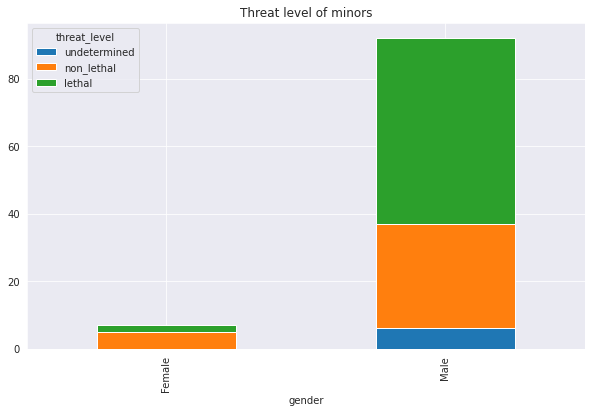

In [157]:
pivot_df = min_df.pivot(index='gender', columns='threat_level', values='value')
pivot_df.loc[:,['undetermined','non_lethal', 'lethal']].plot.bar(stacked=True,figsize=(10,6),title='Threat level of minors')

In [158]:
minor.groupby(['gender','threat_level']).threat_level.count()

gender  threat_level
F       lethal           2
        non_lethal       5
M       lethal          55
        non_lethal      31
        undetermined     6
Name: threat_level, dtype: int64

In [159]:
minor[(minor['armed']!='unarmed') & (minor['threat_level']=='lethal')]

,name,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera,year,weapon,region
78,Jacob Haglund,shot,gun,17.0,M,W,MI,False,lethal,Not fleeing,False,2015,Yes,MidWest
110,Jason C. Hendrix,shot,gun,16.0,M,W,MD,True,lethal,Car,False,2015,Yes,South
134,A'Donte Washington,shot,gun,16.0,M,B,AL,False,lethal,Not fleeing,False,2015,Yes,South
208,Kendre Alston,shot,gun,16.0,M,B,FL,False,lethal,Car,False,2015,Yes,South
252,Justus Howell,shot,gun,17.0,M,B,IL,False,lethal,Foot,False,2015,Yes,MidWest
364,David Gaines,shot,gun,17.0,M,W,CO,False,lethal,Other,False,2015,Yes,West
430,Shelly Haendiges,shot,toy weapon,17.0,F,W,IN,True,lethal,Not fleeing,False,2015,Yes,MidWest
435,Zane Terryn,shot,gun,15.0,M,W,FL,True,lethal,Not fleeing,False,2015,Yes,South
501,Cyrus Hurtado,shot,gun,17.0,M,W,CA,True,lethal,Not fleeing,False,2015,Yes,West
596,Andre Green,shot,NaN,15.0,M,B,IN,False,lethal,Not fleeing,False,2015,Yes,MidWest


SPECULATING ON GUN LAWS

As we see above, almost 54 people classified as minors in USA, were caught and killed when in possession of guns. Commenting about the gun laws in USA, which are shockingly lenient. Possession of handguns is allowed for anyone over the age of 18, but in almost 30 states of the country the laws concerned with possession of rifles and shotguns allow anyone over the ages of 14,15 etc to yield arms.

These rather loose laws make it easy for any kid to procure a firearm, and thus contributes a lot like the aforementioned incidents. It is understandable that adults get these arms for self-defense, but in all case they should be kept away from children. Even if the arms are provided to grown ups they should be well educated and well-trained in its use.

Harmless reported weapon, non-lethal and those who did not flee. Total count 86.

In [161]:
usps[(usps['weapon']=='No') & (usps['threat_level']=='non_lethal') & (usps['flee']=='Not fleeing')]

,name,manner_of_death,armed,age,gender,race,state,signs_of_mental_illness,threat_level,flee,body_camera,year,weapon,region
2,John Paul Quintero,shot and Tasered,unarmed,23.0,M,H,KS,False,non_lethal,Not fleeing,False,2015,No,MidWest
8,Autumn Steele,shot,unarmed,34.0,F,W,IA,False,non_lethal,Not fleeing,True,2015,No,MidWest
86,Joaquin Hernandez,shot,unarmed,28.0,M,H,AZ,False,non_lethal,Not fleeing,False,2015,No,West
107,Richard Carlin,shot,unarmed,35.0,M,H,PA,False,non_lethal,Not fleeing,False,2015,No,NorthEast
114,Lavall Hall,shot and Tasered,unarmed,25.0,M,B,FL,True,non_lethal,Not fleeing,False,2015,No,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076,Stephen O'Brien,shot,unarmed,20.0,M,W,TX,True,non_lethal,Not fleeing,False,2020,No,South
5195,Jose Soto,shot,unarmed,27.0,M,H,CT,True,non_lethal,Not fleeing,False,2020,No,West
5216,Giuseppe Particianone,shot,unarmed,33.0,M,W,PA,False,non_lethal,Not fleeing,False,2020,No,NorthEast
5408,Hannah R. Fizer,shot,unarmed,25.0,F,W,MO,False,non_lethal,Not fleeing,False,2020,No,MidWest
